#### This notebook demonstrates the use of the learning fair representations algorithm for bias mitigation
Learning fair representations [1] is a pre-processing technique that finds a latent representation which encodes the data well but obfuscates information about protected attributes. We will see how to use this algorithm for learning representations that encourage individual fairness and apply them on the Adult dataset.

References:

[1] R. Zemel, Y. Wu, K. Swersky, T. Pitassi, and C. Dwork,  "Learning Fair Representations." 
International Conference on Machine Learning, 2013.

In [67]:
%matplotlib inline
# Load all necessary packages
import sys
sys.path.append("../")
from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
from aif360.algorithms.preprocessing.lfr import LFR
from aif360.sklearn.datasets.utils import standardize_dataset

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from aif360.algorithms.preprocessing.optim_preproc import \
 OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers. \
 opt_tools import OptTools


from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd




In [68]:
# Metrics function
from collections import OrderedDict
from aif360.metrics import ClassificationMetric

def compute_metrics(dataset_true, dataset_pred, 
                    unprivileged_groups, privileged_groups,
                    disp = True):
    """ Compute the key metrics """
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Theil index"] = classified_metric_pred.theil_index()
    
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))
    
    return metrics

In [69]:
import os

import pandas as pd

from aif360.datasets import StandardDataset




class BenefitsDataset(StandardDataset):
    """Adult Census Income Dataset.

    See :file:`aif360/data/raw/adult/README.md`.
    """

    def __init__(self, label_name='checked',
                 favorable_classes=[1],
                 protected_attribute_names=['persoon_geslacht_vrouw', 'typering_ind'],
                 privileged_classes=[[0], [0]],
                 instance_weights_name=None,
                 categorical_features=[],
                 features_to_keep=[], features_to_drop=[],
                 na_values=['?'], custom_preprocessing=None,
                 metadata=None):

        df = pd.read_csv("./../data/synth_data_for_training.csv")

        df = df.astype(np.float32)

        super(BenefitsDataset, self).__init__(df=df, label_name=label_name,
            favorable_classes=favorable_classes,
            protected_attribute_names=protected_attribute_names,
            privileged_classes=privileged_classes,
            instance_weights_name=instance_weights_name,
            categorical_features=categorical_features,
            features_to_keep=features_to_keep,
            features_to_drop=features_to_drop, na_values=na_values,
            custom_preprocessing=custom_preprocessing, metadata=metadata)


#### Load dataset and set options

In [70]:
# Get the dataset and split into train and test
dataset_orig = BenefitsDataset(label_name='checked')
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)
gender_column = dataset_orig.features[:, dataset_orig_train.feature_names.index('persoon_geslacht_vrouw')]


#### Clean up training data

In [71]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(8851, 315)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['persoon_geslacht_vrouw', 'typering_ind']


#### Privileged and unprivileged protected attribute values

[array([0.]), array([0.])] [array([1.]), array([1.])]


#### Dataset feature names

['adres_aantal_brp_adres', 'adres_aantal_verschillende_wijken', 'adres_aantal_verzendadres', 'adres_aantal_woonadres_handmatig', 'adres_dagen_op_adres', 'adres_recentst_onderdeel_rdam', 'adres_recentste_buurt_groot_ijsselmonde', 'adres_recentste_buurt_nieuwe_westen', 'adres_recentste_buurt_other', 'adres_recentste_buurt_oude_noorden', 'adres_recentste_buurt_vreewijk', 'adres_recentste_plaats_other', 'adres_recentste_plaats_rotterdam', 'adres_recentste_wijk_charlois', 'adres_recentste_wijk_delfshaven', 'adres_recentste_wijk_feijenoord', 'adres_recentste_wijk_ijsselmonde', 'adres_recentste_wijk_kralingen_c', 'adres_recentste_wijk_noord', 'adres_recentste_wijk_other', 'adres_recentste_wijk_prins_alexa', 'adres_recentste_wijk_stadscentru', 'adres_unieke_wijk_ratio', 'afspraak_aanmelding_afgesloten', 'afspraak_aantal_woorden', 'afspraak_afgelopen_jaar_afsprakenplan', 'afspraak_afgelopen_jaar_monitoring_insp__wet_taaleis_na_12_mnd_n_a_v__taa04_____geen_maatregel', 'afspraak_afgelopen_jaar_on

#### Metric for original training data

In [72]:
# Metric for the original dataset
privileged_groups = [{'persoon_geslacht_vrouw': 0.0}, {'typering_ind': 0.0}]
unprivileged_groups = [{'persoon_geslacht_vrouw': 1.0}, {'typering_ind': 1.0}]


metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())
metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())


ValueError: 'privileged_groups' and 'unprivileged_groups' must be disjoint.

#### Train with and transform the original training data

In [73]:
scale_orig = StandardScaler()
dataset_orig_train.features = scale_orig.fit_transform(dataset_orig_train.features)
dataset_orig_test.features = scale_orig.transform(dataset_orig_test.features)

In [74]:
optim_options = {
"epsilon": 0.05,
"clist": [0.99, 1.99, 2.99],
"dlist": [.1, 0.05, 0]
}
OP = OptimPreproc(OptTools, optim_options)
OP = OP.fit(dataset_orig_train)
dataset_transf_train = OP.transform(dataset_orig_train,  transform_Y=True)
dataset_transf_train = dataset_orig_train.align_datasets(dataset_transf_train)

d:\tudelft\test-val-for-ai-project\.env\Lib\site-packages\aif360\algorithms\preprocessing\optim_preproc_helpers\opt_tools.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.dfJoint = self.df.groupby(self.features).size().reset_index()
d:\tudelft\test-val-for-ai-project\.env\Lib\site-packages\aif360\algorithms\preprocessing\optim_preproc_helpers\opt_tools.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.dfJoint = self.df.groupby(self.features).size().reset_index()
d:\tudelft\test-val-for-ai-project\.env\Lib\site-p

ValueError: Product space too large to allocate arrays!

In [ ]:
# Input recontruction quality - Ax
# Fairness constraint - Az
# Output prediction error - Ay

privileged_groups = [{'persoon_geslacht_vrouw': 0.0}, {'typering_ind': 0.0}]
unprivileged_groups = [{'persoon_geslacht_vrouw': 1.0}, {'typering_ind': 1.0}]
    
TR = LFR(unprivileged_groups=unprivileged_groups,
         privileged_groups=privileged_groups,
         k=10, Ax=0.1, Ay=1.0, Az=2.0,
         verbose=1
        )
TR = TR.fit(dataset_orig_train, maxiter=5000, maxfun=5000)

ValueError: Only one unprivileged_group or privileged_group supported.

In [ ]:
# Transform training data and align features
dataset_transf_train = TR.transform(dataset_orig_train)
dataset_transf_test = TR.transform(dataset_orig_test)

In [ ]:
print(classification_report(dataset_orig_test.labels, dataset_transf_test.labels))

              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95      3410
         1.0       0.00      0.00      0.00       384

    accuracy                           0.90      3794
   macro avg       0.45      0.50      0.47      3794
weighted avg       0.81      0.90      0.85      3794



d:\tudelft\test-val-for-ai-project\.env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\tudelft\test-val-for-ai-project\.env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\tudelft\test-val-for-ai-project\.env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

In [ ]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())
metric_transf_test = BinaryLabelDatasetMetric(dataset_transf_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Transformed test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_test.mean_difference())


#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


#### Transformed test dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


In [ ]:

display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []

class_thresh_arr = np.linspace(0.01, 0.99, 100)

dataset_transf_test_new = dataset_orig_test.copy(deepcopy=True)
dataset_transf_test_new.scores = dataset_transf_test.scores


for thresh in class_thresh_arr:
    
    fav_inds = dataset_transf_test_new.scores > thresh
    dataset_transf_test_new.labels[fav_inds] = 1.0
    dataset_transf_test_new.labels[~fav_inds] = 0.0
    
    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_new, 
                                      unprivileged_groups, privileged_groups,
                                      disp = False)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])

#### Predictions from transformed testing data

d:\tudelft\test-val-for-ai-project\.env\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
d:\tudelft\test-val-for-ai-project\.env\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


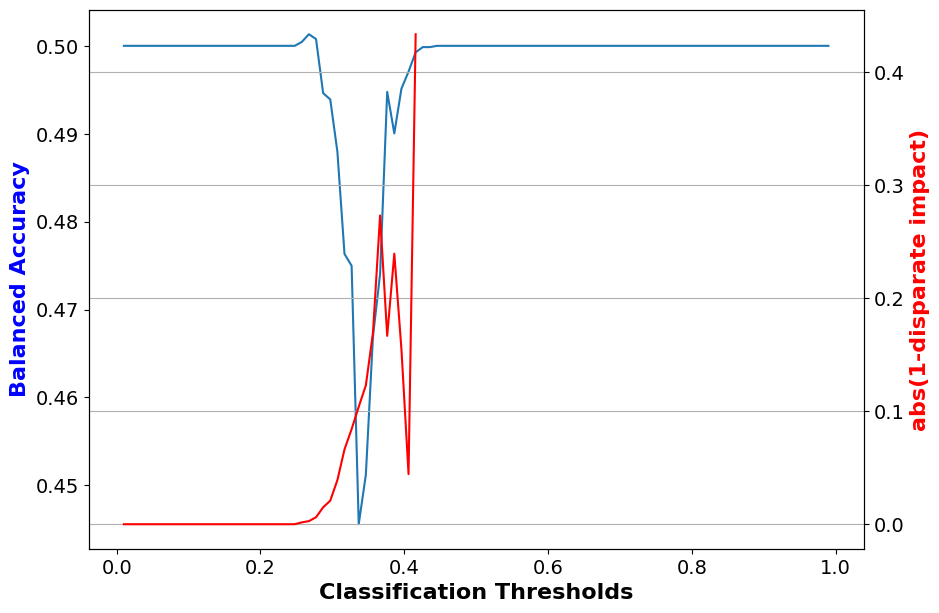

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

abs(1-disparate impact) must be small (close to 0) for classifier predictions to be fair.

In [ ]:
display(Markdown("#### Individual fairness metrics"))
print("Consistency of labels in transformed training dataset= %f" %metric_transf_train.consistency())
print("Consistency of labels in original training dataset= %f" %metric_orig_train.consistency())
print("Consistency of labels in transformed test dataset= %f" %metric_transf_test.consistency())
print("Consistency of labels in original test dataset= %f" %metric_orig_test.consistency())

#### Individual fairness metrics

C:\Users\Rody\AppData\Local\Temp\ipykernel_15864\1464161055.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Consistency of labels in transformed training dataset= %f" %metric_transf_train.consistency())


Consistency of labels in transformed training dataset= 1.000000


C:\Users\Rody\AppData\Local\Temp\ipykernel_15864\1464161055.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Consistency of labels in original training dataset= %f" %metric_orig_train.consistency())


Consistency of labels in original training dataset= 0.888306


C:\Users\Rody\AppData\Local\Temp\ipykernel_15864\1464161055.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Consistency of labels in transformed test dataset= %f" %metric_transf_test.consistency())


Consistency of labels in transformed test dataset= 1.000000
Consistency of labels in original test dataset= 0.894043


C:\Users\Rody\AppData\Local\Temp\ipykernel_15864\1464161055.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Consistency of labels in original test dataset= %f" %metric_orig_test.consistency())


In [ ]:
def check_algorithm_success():
    """Transformed dataset consistency should be greater than original dataset."""
    assert metric_transf_test.consistency() > metric_orig_test.consistency(), "Transformed dataset consistency should be greater than original dataset."

check_algorithm_success()    